# Intro to deep learning for medical imaging by [md.ai](https://www.md.ai)

## Lesson 1. Classification of chest vs. adominal X-rays 

This is a high-level introduction into practical machine learning for purposes of medical image classification. The goal of this tutorial is to build a deep learning classifier to accurately differentiate between chest and abdominal X-rays. The model is trained using 75 images de-identified images obtained from Open-i.

The MD.ai annotator is used to view the DICOM images, and to create the image level annotation. The MD.ai python client library is then used to download images and annotations, prepare the datasets, then are then used to train the model for classification. 

- Original github repo this is based on: https://github.com/ImagingInformatics/machine-learning
- MD.ai annotator project URL: https://public.md.ai/annotator/project/PVq9raBJ
- MD.ai python client libray URL: https://github.com/mdai/mdai-client-py
- MD.ai documentation URL: https://docs.md.ai/

**How to use on Colab: in the menu, go to Runtime -> Change runtime type -> switch to Python 3, and turn on GPU.**

### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [1]:
!pip install --upgrade --quiet mdai

In [2]:
import mdai
mdai.__version__

'0.0.4'

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [3]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="")

Successfully authenticated to public.md.ai.


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `PVq9raBJ` for `https://public.md.ai/annotator/project/PVq9raBJ`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [4]:
p = mdai_client.project('PVq9raBJ', path='/data/HelloWorld')

Using path '/data/HelloWorld' for data.
Preparing annotations export for project PVq9raBJ...                                                
Preparing images export for project PVq9raBJ...                                                     
Using cached images data for project PVq9raBJ.
Using cached annotations data for project PVq9raBJ.


### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [5]:
p.show_label_groups()

Label Group, Id: G_3lv, Name: Default group
	Labels:
	Id: L_yxv, Name: Abdomen
	Id: L_dyy, Name: Chest



In [6]:
# this maps label ids to class ids as a dict obj
labels_dict = {'L_yxv':0, # Abdomen 
               'L_dyy':1, # Chest  
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_yxv': 0, 'L_dyy': 1}


### Create the *Training* and *Validation* datasets

In [7]:
p.show_datasets() 

Datasets:
Id: D_33v, Name: TRAIN
Id: D_vvp, Name: VAL
Id: D_oz1, Name: TEST



In [8]:
# create training dataset 
train_dataset = p.get_dataset_by_name('TRAIN')
train_dataset.prepare() 
train_image_ids = train_dataset.get_image_ids()
print(len(train_image_ids))

# create the validation dataset 
val_dataset = p.get_dataset_by_name('VAL')
val_dataset.prepare()
val_image_ids = val_dataset.get_image_ids()
print(len(val_image_ids))

65
10


### Display a few images

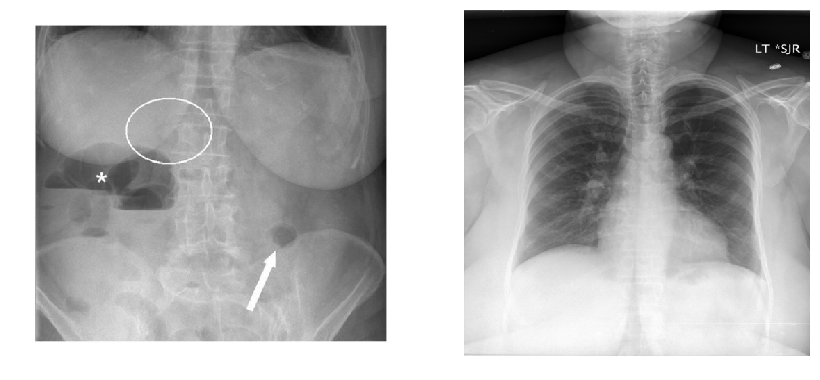

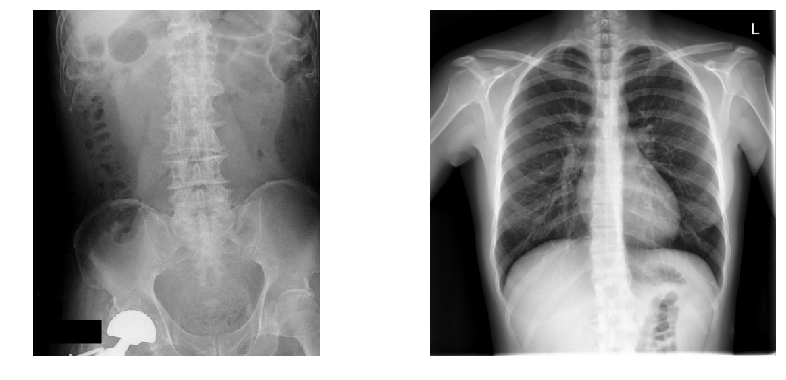

In [9]:
# visualize a few train images 
mdai.visualize.display_images(train_image_ids[:2], cols=2)
mdai.visualize.display_images(val_image_ids[:2], cols=2)

### Use Keras for training and validation

In [10]:
from keras import applications
from keras.models import Model, Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [11]:
# Define model parameters 
img_width = 192
img_height = 192
epochs = 20

params = {
    'dim': (img_width, img_height),
    'batch_size': 5,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

In [13]:
base_model = applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

model_top  = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(2, activation='softmax')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from mdai.utils import keras_utils

train_generator = keras_utils.DataGenerator(train_dataset, **params)
val_generator = keras_utils.DataGenerator(val_dataset, **params)

In [15]:
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [16]:
# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=2),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', 
                    save_best_only=True, verbose=2)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1,            
            validation_data=val_generator,
            use_multiprocessing=True, 
            workers=6)         

Epoch 1/20
13/13 [==============================] - 18s 1s/step - loss: 0.5308 - acc: 0.7385 - val_loss: 0.0450 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.04504, saving model to best_model.h5
Epoch 2/20
13/13 [==============================] - 12s 923ms/step - loss: 0.1399 - acc: 0.9385 - val_loss: 0.0082 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.04504 to 0.00824, saving model to best_model.h5
Epoch 3/20
13/13 [==============================] - 12s 917ms/step - loss: 0.0579 - acc: 0.9846 - val_loss: 0.0023 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00824 to 0.00230, saving model to best_model.h5
Epoch 4/20
13/13 [==============================] - 12s 913ms/step - loss: 0.2125 - acc: 0.9538 - val_loss: 0.0015 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00230 to 0.00147, saving model to best_model.h5
Epoch 5/20
13/13 [==============================] - 12s 912ms/step - loss: 0.0432 - acc: 0.9692 - val_loss: 0.0017 - val_acc: 1

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


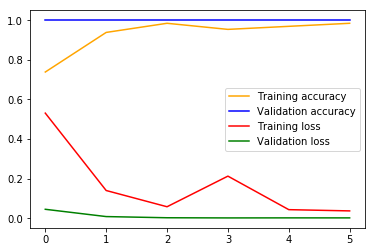

In [17]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

### Create the *Test* dataset

In [18]:
model.load_weights('best_model.h5')

In [19]:
test_dataset = p.get_dataset_by_name('TEST')
test_dataset.prepare()

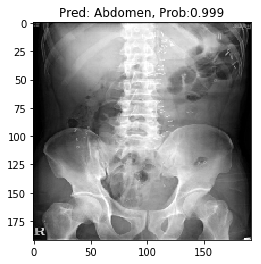

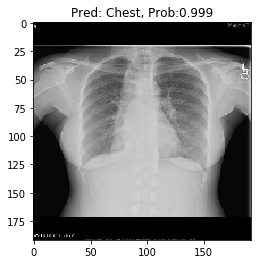

In [20]:
import numpy as np
#from skimage.transform import resize
from PIL import Image 

for image_id in test_dataset.image_ids: 
    
    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))
    
    x = np.expand_dims(image, axis=0)    
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    
    title = 'Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', Prob:' + str(round(y_prob[0][y_classes[0]], 3))
    
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()